In [1]:
%matplotlib inline
import cupy as cp
from cuml.feature_extraction.text import HashingVectorizer
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait
from cuml.dask.common import to_sparse_dask_array
from cuml.dask.feature_extraction.text import TfidfTransformer
import dask_cudf
import cudf
import nltk
import dask
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start

def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v", hue="n_workers")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Create a local CUDA cluster
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="2,3,4,5,6,7")
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 6,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:35921,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33995,Total threads: 1
Dashboard: http://127.0.0.1:36811/status,Memory: 167.97 GiB
Nanny: tcp://127.0.0.1:41931,


In [6]:
def scale_workers(client, n_workers, timeout=300):
    client.cluster.scale(n_workers)
    
    m = len(client.has_what().keys())    
    start = end = time.perf_counter_ns()
    while ((m != n_workers) and (((end - start) / 1e9) < timeout) ):
        time.sleep(5)
        m = len(client.has_what().keys())
        
        end = time.perf_counter_ns()
        
    if (((end - start) / 1e9) >= timeout):
        raise RuntimeError(f"Failed to rescale cluster in {timeout} sec."
              "Try increasing timeout for very large containers, and verify available compute resources.")

def text_preprocessor(s):
    return (s.str.lower()
             .str.replace(PUNCTUATIONS, [" "]*len(PUNCTUATIONS), regex=False)
             .str.replace_tokens(STOPWORDS, "")
             .str.normalize_spaces()
             .str.strip())

def performance_numbers(client, parquet_path, worker_counts=[1], samples=1, data_frac=0.2, result_path="./results.pkl", 
                        seed=42, model_args={}, model_kwargs={}):
    """
    Main function to perform the performance sweep
    """
        
    data_frac = min(1.0, data_frac)
    overall_perf_result = {"data_fraction": data_frac}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        scale_workers(client, n)
        
        for i in tqdm(range(samples)): 
            sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfidftransformer":0, "nrows":0}
            with SimpleTimer() as overalltimer:
                with SimpleTimer() as timer:
                    data = dask_cudf.read_parquet(parquet_path,storage_options={'anon': True, 'use_ssl': False}).sample(frac=data_frac, random_state=seed)
                    with dask.annotate(workers=set(client.has_what().keys())):
                        data = client.persist(data)
                    wait(data)
                sample_record["data_read"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    data = data[data['review_body'].notnull()]
                    data['review_body'] = text_preprocessor(data['review_body'])
                    with dask.annotate(workers=set(client.has_what().keys())):
                        data = client.persist(data)
                    wait(data)
                sample_record["data_preprocessing"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {timer.elapsed}s")
                    
                with SimpleTimer() as timer:
                    vectorizer = HashingVectorizer(stop_words='english', preprocessor=None)
                    # Meta is an empty dataframe matches the dtypes and columns of the output
                    meta = dask.array.from_array(cp.sparse.csr_matrix(cp.zeros(1, dtype=cp.float32))) 
                    X = data["review_body"].map_partitions(vectorizer.fit_transform, meta=meta).astype(cp.float32)
                    with dask.annotate(workers=set(client.has_what().keys())):
                        X = client.persist(X)
                    wait(X)
                    X.compute_chunk_sizes()
                sample_record["hashing_vectorizer"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    multi_gpu_transformer = TfidfTransformer()
                    X_transformed = multi_gpu_transformer.fit_transform(X).persist()
                    with dask.annotate(workers=set(client.has_what().keys())):
                        X_transformed = client.persist(X_transformed)
                    wait(X_transformed)
                    X_transformed.compute_chunk_sizes()
                sample_record["tfidf_transformer"]=timer.elapsed
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=data.shape[0].compute()
            print(f"Workers:{n}, Sample Run:{i}, Finished transforming using TFIDFTransformer in {timer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)
    

In [13]:
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "PC"
parquet_path = f'./data/product_category={dataset}'
model_kwargs = {"text_preprocessor":text_preprocessor}
samples = 5
worker_counts = [2,4,6]
result_path = f"./results/result_poc_nlp_dask_{dataset}.pkl"

In [8]:
%%time
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, data_frac=1, result_path=result_path, 
                        seed=42, model_args={}, model_kwargs=model_kwargs)

  0%|          | 0/5 [00:00<?, ?it/s]

Workers:2, Sample Run:0, Finished loading data in 3728334673s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:2, Sample Run:0, Finished preprocessing data in 7396335619s
# nnz: 0
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 7081738294s
[I] [19:00:52.565596] [Delayed('_merge_stats_to_model-78f7fa4b-4a57-47b7-aa5e-0a7ffd459498')]
[I] [19:00:52.568104] [Delayed('_merge_stats_to_model-e9ee3259-9cd1-402a-964b-ef1a638b6bb8')]
[I] [19:00:52.613560] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-78f7fa4b-4a57-47b7-aa5e-0a7ffd459498>]
[I] [19:00:52.613871] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e9ee3259-9cd1-402a-964b-ef1a638b6bb8>]
[I] [19:00:52.615748] [Delayed('_merge_stats_to_model-f597eb2f-8dec-485b-8163-d9e704ce4474')]


 20%|██        | 1/5 [00:18<01:15, 18.75s/it]

Workers:2, Sample Run:0, Finished transforming using TFIDFTransformer in 502324432s
Workers:2, Sample Run:1, Finished loading data in 1143391146s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:2, Sample Run:1, Finished preprocessing data in 7310685372s
# nnz: 0
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 5634051630s
[I] [19:01:07.183977] [Delayed('_merge_stats_to_model-9aa5f17b-1e51-4cac-9aa3-589489450b72')]
[I] [19:01:07.186399] [Delayed('_merge_stats_to_model-ad374260-6da3-466b-b48b-12f1b28c0d5f')]
[I] [19:01:07.232508] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9aa5f17b-1e51-4cac-9aa3-589489450b72>]
[I] [19:01:07.232790] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ad374260-6da3-466b-b48b-12f1b28c0d5f>]
[I] [19:01:07.235511] [Delayed('_merge_stats_to_model-92238326-83c9-4dbd-8624-b760abafc29b')]


 40%|████      | 2/5 [00:33<00:48, 16.31s/it]

Workers:2, Sample Run:1, Finished transforming using TFIDFTransformer in 471696194s
Workers:2, Sample Run:2, Finished loading data in 1129457298s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:2, Sample Run:2, Finished preprocessing data in 7290368570s
# nnz: 0
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 5648607059s
[I] [19:01:21.767372] [Delayed('_merge_stats_to_model-a7a2c678-d443-4949-be26-17a3f8d10b46')]
[I] [19:01:21.770876] [Delayed('_merge_stats_to_model-442a63c4-9d5c-4486-a53b-ef3511896339')]
[I] [19:01:21.812342] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a7a2c678-d443-4949-be26-17a3f8d10b46>]
[I] [19:01:21.812451] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-442a63c4-9d5c-4486-a53b-ef3511896339>]
[I] [19:01:21.815302] [Delayed('_merge_stats_to_model-a4f30e3c-805e-4b76-bb3f-5128119d3252')]


 60%|██████    | 3/5 [00:47<00:31, 15.52s/it]

Workers:2, Sample Run:2, Finished transforming using TFIDFTransformer in 470736176s
Workers:2, Sample Run:3, Finished loading data in 1120638479s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:2, Sample Run:3, Finished preprocessing data in 7317904100s
# nnz: 0
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 5575683911s
[I] [19:01:36.293735] [Delayed('_merge_stats_to_model-a4238301-cd6a-4a05-95f9-acc225124ff0')]
[I] [19:01:36.296202] [Delayed('_merge_stats_to_model-1491d6c7-f0ae-48d1-9392-7cc79d5fdbe7')]
[I] [19:01:36.336782] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a4238301-cd6a-4a05-95f9-acc225124ff0>]
[I] [19:01:36.337039] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1491d6c7-f0ae-48d1-9392-7cc79d5fdbe7>]
[I] [19:01:36.339132] [Delayed('_merge_stats_to_model-3749ea9c-b5c4-4995-8796-b98491cf51bb')]


 80%|████████  | 4/5 [01:02<00:15, 15.13s/it]

Workers:2, Sample Run:3, Finished transforming using TFIDFTransformer in 456890419s
Workers:2, Sample Run:4, Finished loading data in 1101282879s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:2, Sample Run:4, Finished preprocessing data in 7270809144s
# nnz: 0
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 5579006673s
[I] [19:01:50.751339] [Delayed('_merge_stats_to_model-588a93a7-7d39-4d7e-9a64-bb0d01ac3627')]
[I] [19:01:50.753811] [Delayed('_merge_stats_to_model-1ca8a15f-1f7b-4229-a737-8303d35aeb22')]
[I] [19:01:50.798384] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-588a93a7-7d39-4d7e-9a64-bb0d01ac3627>]
[I] [19:01:50.798634] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1ca8a15f-1f7b-4229-a737-8303d35aeb22>]
[I] [19:01:50.800669] [Delayed('_merge_stats_to_model-812f26dc-5acd-49e7-9c5a-59e396d0e741')]


100%|██████████| 5/5 [01:16<00:00, 15.39s/it]

Workers:2, Sample Run:4, Finished transforming using TFIDFTransformer in 472797745s



  0%|          | 0/5 [00:00<?, ?it/s]

Workers:4, Sample Run:0, Finished loading data in 1531876181s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:4, Sample Run:0, Finished preprocessing data in 5898674491s
# nnz: 0
Workers:4, Sample Run:0, Finished fitting HashVectorizer in 4650035582s
[I] [19:02:08.474539] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4c290dd4-a889-4768-95ed-31a150c505b8>]
[I] [19:02:08.475667] [Delayed('_merge_stats_to_model-c7eaefab-adfd-4c61-9986-a33fc32848b3')]
[I] [19:02:08.477253] [Delayed('_merge_stats_to_model-13102581-4d79-4065-b7af-a70735915f6f')]
[I] [19:02:08.478745] [Delayed('_merge_stats_to_model-913f4d0e-bf93-4c60-bdf8-b6fe2c250987')]
[I] [19:02:08.506506] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4c290dd4-a889-4768-95ed-31a150c505b8>]
[I] [19:02:08.506714] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-c7eaefab-adfd-4c61-9986-a33fc32848b3>]
[I] [19:02:08.506887] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-13102581-4d79-4065-b7af-a70735915f6f>]
[I] [19:02:08.507058] [<Future: fin

 20%|██        | 1/5 [00:12<00:51, 12.80s/it]

Workers:4, Sample Run:0, Finished transforming using TFIDFTransformer in 676208495s
Workers:4, Sample Run:1, Finished loading data in 746023564s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:4, Sample Run:1, Finished preprocessing data in 4422163658s
# nnz: 0
Workers:4, Sample Run:1, Finished fitting HashVectorizer in 3469725110s
[I] [19:02:17.812438] [Delayed('_merge_stats_to_model-8eeb4636-9af5-4085-8338-c7e4d8c94559')]
[I] [19:02:17.813929] [Delayed('_merge_stats_to_model-10681d29-d4e9-4cf0-b61c-0e5663504fc7')]
[I] [19:02:17.814773] [Delayed('_merge_stats_to_model-33c5e737-1be3-4e36-81c6-7589b50cb189')]
[I] [19:02:17.815730] [Delayed('_merge_stats_to_model-08b4c12a-9c48-4527-b841-331214d150dc')]
[I] [19:02:17.846140] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8eeb4636-9af5-4085-8338-c7e4d8c94559>]
[I] [19:02:17.846386] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-10681d29-d4e9-4cf0-b61c-0e5663504fc7>]
[I] [19:02:17.846558] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-33c5e737-1be3-4e36-81c6-7589b50cb189>]
[I] [19:02:17.846739] [<Future: finished, type: cuml.TfidfTransf

 40%|████      | 2/5 [00:21<00:31, 10.65s/it]

Workers:4, Sample Run:1, Finished transforming using TFIDFTransformer in 457769284s
Workers:4, Sample Run:2, Finished loading data in 836442200s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:4, Sample Run:2, Finished preprocessing data in 4415802076s
# nnz: 0
Workers:4, Sample Run:2, Finished fitting HashVectorizer in 3669725851s
[I] [19:02:27.238964] [Delayed('_merge_stats_to_model-2aadfbb8-0cd0-4850-b6f4-6c319f38f144')]
[I] [19:02:27.240565] [Delayed('_merge_stats_to_model-44f75f1c-76de-4f23-be93-9159cb35f7f3')]
[I] [19:02:27.241366] [Delayed('_merge_stats_to_model-d3b166a6-ea78-405d-a40e-851a1c85d73c')]
[I] [19:02:27.242165] [Delayed('_merge_stats_to_model-ca0e2941-e29d-4240-af2b-db69cec1b90c')]
[I] [19:02:27.272212] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2aadfbb8-0cd0-4850-b6f4-6c319f38f144>]
[I] [19:02:27.272331] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-44f75f1c-76de-4f23-be93-9159cb35f7f3>]
[I] [19:02:27.272611] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d3b166a6-ea78-405d-a40e-851a1c85d73c>]
[I] [19:02:27.272789] [<Future: finished, type: cuml.TfidfTransf

 60%|██████    | 3/5 [00:31<00:20, 10.08s/it]

Workers:4, Sample Run:2, Finished transforming using TFIDFTransformer in 445351744s
Workers:4, Sample Run:3, Finished loading data in 784300889s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:4, Sample Run:3, Finished preprocessing data in 4394830308s
# nnz: 0
Workers:4, Sample Run:3, Finished fitting HashVectorizer in 3472331586s
[I] [19:02:36.378539] [Delayed('_merge_stats_to_model-0f5a14a2-6f80-458e-8030-b6e8aba073cd')]
[I] [19:02:36.380191] [Delayed('_merge_stats_to_model-a2c03c22-2a21-4a97-bdf5-8a144648685e')]
[I] [19:02:36.380994] [Delayed('_merge_stats_to_model-229bac06-2f7a-41c6-875d-02d238d6b25a')]
[I] [19:02:36.381780] [Delayed('_merge_stats_to_model-e071944e-d400-4c0a-a721-c7f819d50381')]
[I] [19:02:36.409899] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0f5a14a2-6f80-458e-8030-b6e8aba073cd>]
[I] [19:02:36.410147] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a2c03c22-2a21-4a97-bdf5-8a144648685e>]
[I] [19:02:36.410318] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-229bac06-2f7a-41c6-875d-02d238d6b25a>]
[I] [19:02:36.410481] [<Future: finished, type: cuml.TfidfTransf

 80%|████████  | 4/5 [00:40<00:09,  9.74s/it]

Workers:4, Sample Run:3, Finished transforming using TFIDFTransformer in 511804532s
Workers:4, Sample Run:4, Finished loading data in 766951229s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:4, Sample Run:4, Finished preprocessing data in 4584414196s
# nnz: 0
Workers:4, Sample Run:4, Finished fitting HashVectorizer in 3496896724s
[I] [19:02:45.781952] [Delayed('_merge_stats_to_model-a4ed7265-7798-499e-8dd4-017ead6e41fe')]
[I] [19:02:45.782768] [Delayed('_merge_stats_to_model-976acdd3-25c9-4636-b73e-b18582b65ce6')]
[I] [19:02:45.787344] [Delayed('_merge_stats_to_model-20eea099-3845-4b88-9a4c-698bb5f08043')]
[I] [19:02:45.788219] [Delayed('_merge_stats_to_model-7507c817-f5a7-4486-b207-8292dbbf63ac')]
[I] [19:02:45.819534] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a4ed7265-7798-499e-8dd4-017ead6e41fe>]
[I] [19:02:45.819809] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-976acdd3-25c9-4636-b73e-b18582b65ce6>]
[I] [19:02:45.820046] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-20eea099-3845-4b88-9a4c-698bb5f08043>]
[I] [19:02:45.820237] [<Future: finished, type: cuml.TfidfTransf

100%|██████████| 5/5 [00:49<00:00,  9.99s/it]

Workers:4, Sample Run:4, Finished transforming using TFIDFTransformer in 505646682s



  0%|          | 0/5 [00:00<?, ?it/s]

Workers:6, Sample Run:0, Finished loading data in 1586009488s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:6, Sample Run:0, Finished preprocessing data in 3193449988s
# nnz: 0
Workers:6, Sample Run:0, Finished fitting HashVectorizer in 2601403289s
[I] [19:02:58.845511] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1e119ed4-22e7-4486-aa36-4471a7a047bc>]
[I] [19:02:58.845781] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-cefda825-c0ae-4bdf-8498-002b9ed9eb10>]
[I] [19:02:58.846595] [Delayed('_merge_stats_to_model-6600aad1-568f-4202-9090-f66c4eac87b8')]
[I] [19:02:58.847386] [Delayed('_merge_stats_to_model-02ed92cb-8414-429a-817e-cf8d880d95b8')]
[I] [19:02:58.848250] [Delayed('_merge_stats_to_model-b630737e-9c9b-4f1f-80a3-2ae83aca3897')]
[I] [19:02:58.849189] [Delayed('_merge_stats_to_model-12192bbd-07a8-49ee-990b-11f9409e2857')]
[I] [19:02:58.867605] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1e119ed4-22e7-4486-aa36-4471a7a047bc>]
[I] [19:02:58.867716] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_

 20%|██        | 1/5 [00:07<00:31,  7.86s/it]

Workers:6, Sample Run:0, Finished transforming using TFIDFTransformer in 427696695s
Workers:6, Sample Run:1, Finished loading data in 628378227s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:6, Sample Run:1, Finished preprocessing data in 3145649433s
# nnz: 0
Workers:6, Sample Run:1, Finished fitting HashVectorizer in 2626905652s
[I] [19:03:05.728941] [Delayed('_merge_stats_to_model-f481c973-85bc-41d3-97b7-d4b70e96162e')]
[I] [19:03:05.729862] [Delayed('_merge_stats_to_model-d3d2f402-a09d-4e1b-83cc-96079d6fc1f9')]
[I] [19:03:05.730706] [Delayed('_merge_stats_to_model-ab8446bc-680b-4bd5-8ba3-24b4e2e5aa57')]
[I] [19:03:05.731636] [Delayed('_merge_stats_to_model-d2206b11-fd9f-4fa1-8e7e-38fb81423062')]
[I] [19:03:05.731905] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-d37e352b-678b-456e-af0b-d3e84d64a1cb>]
[I] [19:03:05.732137] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-bffb2208-85e0-4f2b-b88b-789bffec74fd>]
[I] [19:03:05.749976] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f481c973-85bc-41d3-97b7-d4b70e96162e>]
[I] [19:03:05.750230] [<Future: finished, type: cuml.TfidfTransformer, key: _m

 40%|████      | 2/5 [00:14<00:21,  7.29s/it]

Workers:6, Sample Run:1, Finished transforming using TFIDFTransformer in 444390555s
Workers:6, Sample Run:2, Finished loading data in 611148273s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:6, Sample Run:2, Finished preprocessing data in 3127023684s
# nnz: 0
Workers:6, Sample Run:2, Finished fitting HashVectorizer in 2583057424s
[I] [19:03:12.547439] [Delayed('_merge_stats_to_model-bc3a323c-298b-4832-b880-385b53916cc7')]
[I] [19:03:12.548319] [Delayed('_merge_stats_to_model-26a110b3-0f8f-4dde-b542-9bcc30e6a261')]
[I] [19:03:12.549178] [Delayed('_merge_stats_to_model-c6a3406a-7d07-4a97-a7cd-ede977e95d17')]
[I] [19:03:12.549969] [Delayed('_merge_stats_to_model-5e69d624-f506-458a-a6fb-d08ebe5565eb')]
[I] [19:03:12.550241] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ba0faf7b-4ac4-43f5-95c1-a50ef2fe2354>]
[I] [19:03:12.550423] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-5f12fff9-a34a-460f-9288-5d9fe7d96fd4>]
[I] [19:03:12.567951] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-bc3a323c-298b-4832-b880-385b53916cc7>]
[I] [19:03:12.570903] [<Future: finished, type: cuml.TfidfTransformer, key: _m

 60%|██████    | 3/5 [00:21<00:14,  7.07s/it]

Workers:6, Sample Run:2, Finished transforming using TFIDFTransformer in 439858473s
Workers:6, Sample Run:3, Finished loading data in 594408216s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:6, Sample Run:3, Finished preprocessing data in 3164570584s
# nnz: 0
Workers:6, Sample Run:3, Finished fitting HashVectorizer in 2515940599s
[I] [19:03:19.299464] [Delayed('_merge_stats_to_model-4bdcfd1e-c595-4f90-a55f-e0822d3bf4f5')]
[I] [19:03:19.300400] [Delayed('_merge_stats_to_model-ff15d491-2772-401e-ba3d-4b22edf372a1')]
[I] [19:03:19.301286] [Delayed('_merge_stats_to_model-d633b32f-60f0-405d-9349-44bdc2b07ae6')]
[I] [19:03:19.302119] [Delayed('_merge_stats_to_model-33a88a4e-a7ac-4b53-a802-8231d219cf40')]
[I] [19:03:19.302376] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-853b9f40-41f5-4348-b834-d5410b258dc7>]
[I] [19:03:19.302545] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ab87377b-fcff-4117-b846-9ad36964590e>]
[I] [19:03:19.319936] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4bdcfd1e-c595-4f90-a55f-e0822d3bf4f5>]
[I] [19:03:19.320204] [<Future: finished, type: cuml.TfidfTransformer, key: _m

 80%|████████  | 4/5 [00:28<00:06,  6.94s/it]

Workers:6, Sample Run:3, Finished transforming using TFIDFTransformer in 432431329s
Workers:6, Sample Run:4, Finished loading data in 602291504s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


Workers:6, Sample Run:4, Finished preprocessing data in 3162203707s
# nnz: 0
Workers:6, Sample Run:4, Finished fitting HashVectorizer in 2520000306s
[I] [19:03:26.064252] [Delayed('_merge_stats_to_model-861bb4dc-d221-4b16-8922-67d17274ce04')]
[I] [19:03:26.065127] [Delayed('_merge_stats_to_model-655587f2-07cf-4cbb-8d16-8765b5a1b88d')]
[I] [19:03:26.066093] [Delayed('_merge_stats_to_model-71719954-b756-406e-b853-65baf064cfb5')]
[I] [19:03:26.067071] [Delayed('_merge_stats_to_model-32ad8264-dd68-4081-851a-2ae6934927d5')]
[I] [19:03:26.067396] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-a6c59532-880f-42f7-b147-9700f861afb9>]
[I] [19:03:26.067617] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6ee726ae-8626-4a76-9e70-fd6f07d50f97>]
[I] [19:03:26.085473] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-861bb4dc-d221-4b16-8922-67d17274ce04>]
[I] [19:03:26.085724] [<Future: finished, type: cuml.TfidfTransformer, key: _m

100%|██████████| 5/5 [00:35<00:00,  7.03s/it]

Workers:6, Sample Run:4, Finished transforming using TFIDFTransformer in 433876459s
CPU times: user 10.8 s, sys: 2.66 s, total: 13.4 s
Wall time: 2min 57s


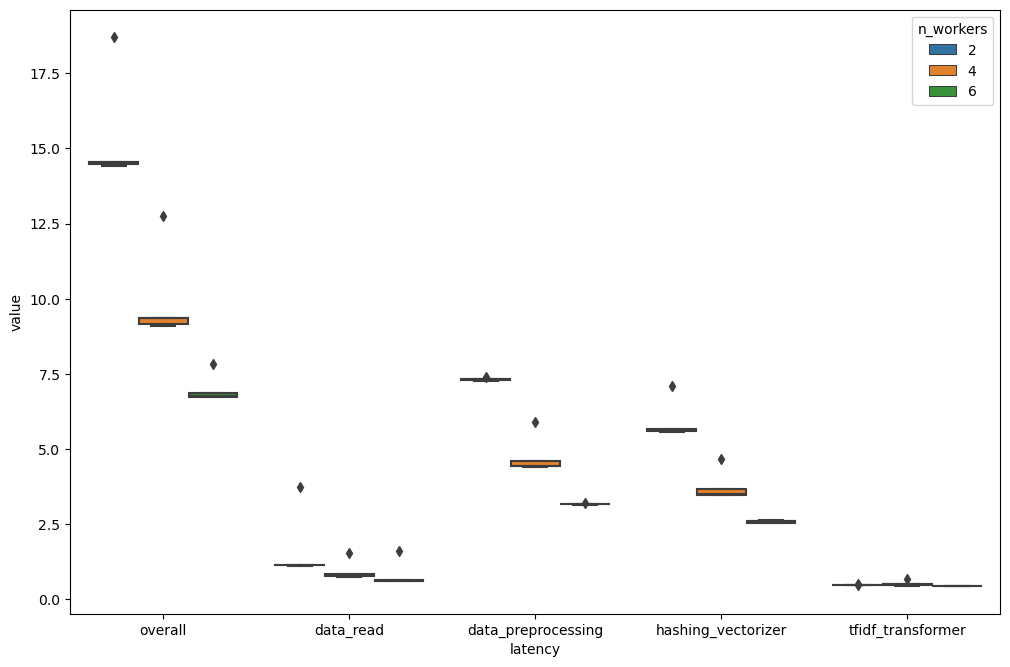

In [9]:
data, melt_data = visualize_data(result_path)        

In [10]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [11]:
groupy

sample_run                    overall                 data_read  \
                mean       std count       mean       std count      mean   
n_workers                                                                   
2                  2  1.581139     5  15.340989  1.883721     5  1.644621   
4                  2  1.581139     5   9.947924  1.574986     5  0.933119   
6                  2  1.581139     5   6.968639  0.472867     5  0.804447   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
2          1.164932     5           7.317221  ...     5           5.903818   
4          0.336385     5           4.743177  ...     5           3.751743   
6          0.437089     5           3.158579  ...     5           2.569461   

                          tfidf_transformer                    nrows       \
                std count              mean       std count     mean  std   
n_workers                                                                   
2          0.659276     5          0.474889  0.016647     5  7004147  0.0   
4          0.508971     5          0.519356  0.092354     5  7004147  0.0   
6          0.049537     5          0.435651  0.006536     5  7004147  0.0   

                 
          count  
n_workers        
2             5  
4             5  
6             5  

[3 rows x 21 columns]

In [14]:
client.close()
cluster.close()